In [203]:
import pandas as pd
import nltk
import nltk.data
from nltk.tokenize import word_tokenize
import numpy as np
from convokit import Corpus, download, FightingWords, Utterance, Speaker
from collections import Counter, defaultdict
from torchtext.vocab import GloVe
from utils.corpus import get_corpus
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import metrics
import matplotlib.pyplot as plt

In [20]:
def corpus_from_source(source, field, n):
    df, _  = get_corpus(source, text_field=field, split_sentences=True, punct=False, to_ascii=True,
                min_len=3, max_len=15,  test_size=0.0001, subsample_rows=n, save=False)
    speaker = Speaker(meta={'name': source})
    utts = [Utterance(id=f'{source}{i}', text=' '.join(t), speaker=speaker) for i, t in enumerate(df.utterance) ]
    corp = Corpus(utterances=utts)
    return df, corp

def compare_corpora(c1, c2, n1, n2):
    print(n1)
    c1.print_summary_stats()
    print(c1.get_utterances_dataframe().text.map(lambda x: x.split()).map(len).describe())
    print('\n'.join(c1.random_utterance().text for _ in range(10)))
    print('\n')
    print(n2)
    c2.print_summary_stats()
    print(c2.get_utterances_dataframe().text.map(lambda x: x.split()).map(len).describe())
    print('\n'.join(c2.random_utterance().text for _ in range(10)))
    ids1 = set(c1.get_utterance_ids())
    corp = c1.merge(c2)
    fw = FightingWords(ngram_range=(1,1))
    fw.fit(corp, class1_func=lambda utt: utt.id in ids1, 
                 class2_func=lambda utt: utt.id not in ids1)
    print(fw.summarize(corp, plot=False, class1_name=n1,
                                          class2_name=n2))
    return fw
    
def run_comparison(source1, field1, source2, field2, n=1000):
    print('loading ', source1)
    df1, c1 = corpus_from_source(source1, field1, n)
    print('loading ', source2)
    df2, c2 = corpus_from_source(source2, field2, n)
    return df1, df2, compare_corpora(c1, c2, source1, source2)

def word_freqs_in_vocab(data, voc, n=1000):
    return Counter(w if w in voc else 'unk' for s in data.iloc[:n] for w in s)

def word_freqs(data, n=1000):
    return Counter(w for s in data.iloc[:n] for w in s)

In [21]:
# imdb = pd.read_csv('data_options/IMDB Dataset.csv')
# food = pd.read_csv('data_options/Reviews.csv')
# movies = pd.read_csv('data_options/movies_metadata.csv')
# tmbd = pd.read_csv('data_options/tmdb_5000_movies.csv')
# hotels = pd.read_csv('data_options/tripadvisor_hotel_reviews.csv')

In [22]:
with open('data/google-10000-english-usa.txt', 'r') as fh:
    vocab10k = set(t.strip() for t in fh.readlines())
g = GloVe('6B',dim=50)
glove_vocab = set(g.stoi)

In [202]:
general_word_freqs = pd.read_csv('data/unigram_freq.csv')

In [240]:
n = 50000

In [258]:
df1, df2, fw = run_comparison('friends-corpus', 'text', 'supreme-corpus', 'text', n=n)

loading  friends-corpus
Dataset already exists at /Users/janek/.convokit/downloads/friends-corpus
Cleaning
50428
6
loading  supreme-corpus
Cleaning
55796
6
friends-corpus
Number of Speakers: 1
Number of Utterances: 50428
Number of Conversations: 1
count    50428.000000
mean         6.932835
std          3.249427
min          3.000000
25%          4.000000
50%          6.000000
75%          9.000000
max         15.000000
Name: text, dtype: float64
oh we 're kidding
well she wore it all christmas day and then uh
well monica and chandler ca n't go
hi you 're chandler bing right
hey did i do these neat enough
what is this
oh it was great
oh my god
wait a minute hold it
well there 's rachel and umm i think that 's it


supreme-corpus
Number of Speakers: 1
Number of Utterances: 55796
Number of Conversations: 1
count    55796.000000
mean         8.268908
std          3.673627
min          3.000000
25%          5.000000
50%          8.000000
75%         11.000000
max         15.000000
Name: te

In [259]:
df1.shape, df2.shape

((50428, 1), (55796, 1))

In [260]:
c1 = word_freqs(df1.utterance, n=n)
c1v = word_freqs_in_vocab(df1.utterance, voc=glove_vocab, n=n)
c1v10k = word_freqs_in_vocab(df1.utterance, voc=vocab10k, n=n)
c2 = word_freqs(df2.utterance, n=n)
c2v = word_freqs_in_vocab(df2.utterance, voc=glove_vocab, n=n)
c2v10k = word_freqs_in_vocab(df2.utterance, voc=vocab10k, n=n)

In [261]:
# out of vocab
c1v['unk']/sum(c1.values()), c2v['unk']/sum(c2.values()), c1v10k['unk'], c2v10k['unk']

(0.006785587550524066, 0.0018719299985247063, 44612, 43388)

In [262]:

len(c1.keys()), len(c2.keys()), len(set(c1.keys()) - set(c2.keys())), len(set(c2.keys()) - set(c1.keys()))

(11088, 11820, 6900, 7632)

In [263]:
oov1 = 0
for key in set(c1.keys()) - set(c2.keys()):
    oov1 += c1[key]
    if c1[key] > 15:
        print(key, c1[key])
oov1/sum(c1.values())

ohhh 19
jealous 27
massage 32
quit 43
goodbye 30
bye 115
jokes 26
guest 25
drink 54
hates 25
oooh 21
ate 26
toast 18
tribbiani 46
honeymoon 18
stripper 17
tired 29
frank 27
mona 26
wh 76
gosh 22
mon 70
lesbian 23
duck 37
mommy 19
gim 19
wedding 150
drake 34
pants 76
dude 76
chef 29
grandma 17
naked 86
joey 724
hair 89
dating 35
dad 150
estelle 17
porn 44
phoebs 22
tickets 47
bra 24
breasts 24
drunk 49
breast 16
twins 17
vegas 24
legs 17
ohh 159
freak 35
feelings 32
birthday 95
kathy 21
rachel 548
christmas 46
amy 21
c'mon 72
toe 17
carol 53
bucks 41
ladies 27
movies 16
sooo 21
ya 300
cute 100
ugh 38
ha 90
goin 37
uhm 71
janice 41
fan 25
bedroom 31
shower 34
club 19
ho 74
pal 18
sing 23
divorced 26
coat 33
chandler 581
hug 29
elizabeth 24
tulsa 24
london 41
cat 79
'bout 19
tonight 193
alright 245
dunno 17
pottery 16
girlfriend 54
pictures 18
asleep 26
sucks 19
gym 18
umm 371
relax 43
hmm 48
paris 19
outta 18
sandwich 36
butt 35
kiss 83
plane 39
pack 17
um 251
'til 16
girl 193
dressed 34

0.08927144369722201

In [264]:
oov2 = 0
for key in set(c2.keys()) - set(c1.keys()):
    oov2 += c2[key]
    if c2[key] > 20:
        print(key, c2[key])
oov2/sum(c2.values())

extraordinary 27
consequence 33
respondents 31
statements 30
contrary 72
additional 49
requirements 44
premise 22
district 274
preemption 31
liability 40
requirement 92
arguments 50
summary 40
discrimination 85
preclusion 38
underlying 24
regulation 62
petitioner 75
administrative 64
issued 29
reply 31
subsection 30
interpret 23
prosecutor 87
statute 676
satisfy 23
drawn 21
affidavit 38
settlement 22
sovereign 50
employee 55
equipoise 24
counsel 301
petitioners 40
ginsburg 230
refer 45
experts 21
remainder 33
applies 77
characterization 28
impose 27
consideration 36
ambiguous 30
dreeben 23
conviction 71
initial 24
jurisdictional 75
delay 29
waiver 63
among 23
remedies 38
answered 37
education 22
aggravating 43
concede 60
charged 37
limitation 35
legislation 25
cert 37
granted 35
allows 28
honors 28
equitable 54
relying 28
precise 27
adequate 28
lawyers 25
involving 24
purposes 82
indication 26
inherent 26
carolina 22
text 64
roberts 24
intended 50
unlawful 37
taxes 31
conceded 24
affir

0.10110840506243395

## Baseline 1: frequency based likelihoods

In [265]:
total_vocab = list(set(c1.keys()) | set(c2.keys()))

In [266]:
eps = 1e-8
vect = CountVectorizer(ngram_range=(1,1), analyzer='word', vocabulary=total_vocab)
v1 = vect.transform(df1.utterance.apply(' '.join))
v1 = v1[v1.getnnz(1)>0][:n]
v2 = vect.transform(df2.utterance.apply(' '.join))
v2 = v2[v2.getnnz(1)>0][:n]
freq1 = v1.sum(axis=0)[0]/v1.sum() + eps
freq2 = v2.sum(axis=0)[0]/v2.sum() + eps


In [267]:
freq_dict = defaultdict(int, general_word_freqs.set_index('word')['count'].to_dict())
general_freq = np.array([freq_dict[w] for w in total_vocab])
general_freq = general_freq/sum(general_freq) + eps

In [268]:
def get_log_likelihoods(vectorized, frequencies): # normalized by length
    w = vectorized.multiply(frequencies).tocsr()
    log_likes = []
    for i in range(w.shape[0]):
        _, ind = w[i].nonzero()
        if len(ind) == 0:
            print(i)
            raise Exception
        log_likes.append(sum(np.log(w[i,j]) for j in ind)/len(ind))
    print('done')
    return np.array(log_likes)

In [269]:
ll1_f1 = get_log_likelihoods(v1, freq1) # likelihoods of samples in 1 given frequencies in 1
ll2_f1 = get_log_likelihoods(v2, freq1) # likelihoods of samples in 2 given frequencies in 1
ll1_f2 = get_log_likelihoods(v1, freq2) 
ll2_f2 = get_log_likelihoods(v2, freq2) 
ll1_general = get_log_likelihoods(v1, general_freq) 
ll2_general = get_log_likelihoods(v2, general_freq) 

done
done
done
done
done
done


In [270]:
pd.Series(ll1_general).describe(), pd.Series(ll2_general).describe()

(count    50000.000000
 mean        -7.559298
 std          1.183934
 min        -18.420681
 25%         -8.118036
 50%         -7.400780
 75%         -6.780029
 max         -2.533999
 dtype: float64,
 count    50000.000000
 mean        -7.195983
 std          1.020881
 min        -18.420681
 25%         -7.714073
 50%         -7.087811
 75%         -6.536631
 max         -2.651156
 dtype: float64)

In [271]:
pd.Series(ll1_f1).describe(), pd.Series(ll2_f1).describe()

(count    50000.000000
 mean        -6.145629
 std          1.122891
 min        -12.611973
 25%         -6.748010
 50%         -6.020776
 75%         -5.391860
 max         -2.250780
 dtype: float64,
 count    50000.000000
 mean        -7.669764
 std          1.841548
 min        -18.420681
 25%         -8.872985
 50%         -7.513372
 75%         -6.309150
 max         -2.820068
 dtype: float64)

In [272]:
pd.Series(ll2_f2).describe(), pd.Series(ll1_f2).describe()

(count    50000.000000
 mean        -6.121739
 std          0.985878
 min        -12.833427
 25%         -6.729997
 50%         -6.083301
 75%         -5.466912
 max         -2.389741
 dtype: float64,
 count    50000.000000
 mean        -7.881842
 std          2.208282
 min        -18.420681
 25%         -8.974461
 50%         -7.534314
 75%         -6.354961
 max         -2.869730
 dtype: float64)

0.75936192
0.7713719044


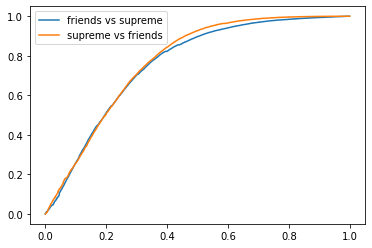

In [279]:
x = np.concatenate([ll1_f1, ll2_f1])
y = np.concatenate([np.ones_like(ll1_f1), np.zeros_like(ll2_f1)]).astype(int)
fpr, tpr, thresholds = metrics.roc_curve(y, x)
plt.plot(fpr, tpr, label='friends vs supreme')
print(metrics.roc_auc_score(y, x))
x = np.concatenate([ll2_f2, ll1_f2])
y = np.concatenate([np.ones_like(ll2_f2), np.zeros_like(ll1_f2)]).astype(int)
fpr, tpr, thresholds = metrics.roc_curve(y, x)
plt.plot(fpr, tpr, label='supreme vs friends')
print(metrics.roc_auc_score(y, x))
plt.legend()

In [283]:
# TODO: train-test split
# TODO: one sided vocabulary ? - I guess it is, because 0-frequencies

0.8895215044
0.775596065


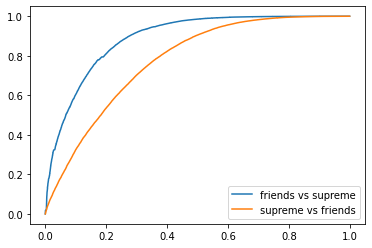

In [282]:
x = np.concatenate([ll1_f1 - ll1_general, ll2_f1 - ll2_general])
y = np.concatenate([np.ones_like(ll1_f1), np.zeros_like(ll2_f1)]).astype(int)
fpr, tpr, thresholds = metrics.roc_curve(y, x)
plt.plot(fpr, tpr, label='friends vs supreme')
print(metrics.roc_auc_score(y, x))
x = np.concatenate([ll2_f2 - ll1_general, ll1_f2 - ll2_general])
y = np.concatenate([np.ones_like(ll2_f2), np.zeros_like(ll1_f2)]).astype(int)
fpr, tpr, thresholds = metrics.roc_curve(y, x)
plt.plot(fpr, tpr, label='supreme vs friends')
print(metrics.roc_auc_score(y, x))
plt.legend()

In [185]:
y

array([1., 1., 1., ..., 0., 0., 0.])

## Baseline 2: OOV

In [17]:
friends = Corpus(filename=download("friends-corpus"))
# supreme = Corpus(filename=download("supreme-corpus"))
# # parliament = Corpus(filename=download("parliament-corpus"))
# movie = Corpus(filename=download("movie-corpus"))
# diplomacy = Corpus(filename=download("diplomacy-corpus")) # game, written
# switchboard = Corpus(filename=download("switchboard-corpus")) # conversational, from spoken
# reddit = Corpus(filename=download('reddit-corpus-small'))
# tennis = Corpus(filename=download('tennis-corpus'))

Dataset already exists at /Users/janek/.convokit/downloads/friends-corpus


In [284]:

import torch
import torch.nn as nn

In [287]:
g